In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import ascii, fits
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import Angle
import glob
#import splat
%matplotlib inline
Gaia.ROW_LIMIT = -1

In [2]:
#df=ascii.read('/volumes/LaCie/hejazi/astrometry.txt').to_pandas()
#df

#df_class=ascii.read('/Volumes/LaCie/hejazi/classifications.txt').to_pandas()

In [3]:
#bools=df_class.SpType.str.contains('sd')

In [4]:
#GAIA_ID= 6025146733201615616
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
#source https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products#datalink_serialisation

In [5]:
Gaia.cross_match

<bound method GaiaClass.cross_match of <astroquery.gaia.core.GaiaClass object at 0x7fcb2bce0f70>>

In [46]:
coord1 = SkyCoord(ra=43.26964247679, dec=16.86437381898, unit=(u.degree, u.degree), frame='icrs')
coord2= SkyCoord(ra=64.13094408963, dec=-28.31582574236, unit=(u.degree, u.degree), frame='icrs')
coord=SkyCoord([coord1, coord2])
r= u.Quantity(1, u.arcsec)
r = [Gaia.query_object_async(coordinate=c, radius=r) for c in coord]

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [56]:
res=pd.concat([x.to_pandas() for x in r])

In [61]:
list(res.columns)

['solution_id',
 'DESIGNATION',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

In [9]:
#res.ID

In [10]:
#res.to_csv('/volumes/LaCie/hejazi/gaia_crossmatch.txt')

In [53]:
IDS=res.source_id.values
#IDS=[5227046884571776, 4886243456388510720]

In [103]:
retrieval_type = 'XP_CONTINUOUS'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'COMBINED'     # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink  = Gaia.load_data(ids=IDS, data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')


The following Datalink products have been downloaded:
 * XP_CONTINUOUS-Gaia DR3 4886243456388510720.xml


In [98]:
def extract_dl_ind(datalink_dict, key, figsize = [15,5], fontsize = 12, linewidth = 2, show_legend = True, show_grid = True):
    ""
    "Extract individual DataLink products and export them to an Astropy Table"
    ""
    dl_out  = datalink_dict[key][0].to_table()
    if 'time' in dl_out.keys():
        plot_e_phot(dl_out, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = fontsize, show_legend = show_legend, show_grid = show_grid, figsize = figsize)
    if 'wavelength' in dl_out.keys():
        if len(dl_out) == 343:  title = 'XP Sampled'
        if len(dl_out) == 2401: title = 'RVS'
        plot_sampled_spec(dl_out, color = 'blue', title = title, fontsize = fontsize, show_legend = False, show_grid = show_grid, linewidth = linewidth, legend = '', figsize = figsize)
    return dl_out


def plot_e_phot(inp_table, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = 12, show_legend = True, show_grid = True, figsize = [15,5]):
    ""
    "Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    fig      = plt.figure(figsize=figsize)
    xlabel   = f'JD date [{inp_table["time"].unit}]'
    ylabel   = f'magnitude [{inp_table["mag"].unit}]'
    gbands   = ['G', 'RP', 'BP']
    colours  = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table['band'] == band]
        plt.plot(phot_set['time'], phot_set['mag'], 'o', label = band, color = next(colours))
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    plt.show()


def plot_sampled_spec(inp_table, color = 'blue', title = '', fontsize = 14, show_legend = True, show_grid = True, linewidth = 2, legend = '', figsize = [12,4], show_plot = True):
    ""
    "RVS & XP sampled spectrum plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    if show_plot:
        fig      = plt.figure(figsize=figsize)
    xlabel   = f'Wavelength [{inp_table["wavelength"].unit}]'
    ylabel   = f'Flux [{inp_table["flux"].unit}]'
    plt.plot(inp_table['wavelength'], inp_table['flux'], '-', linewidth = linewidth, label = legend)
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    if show_plot:
        plt.show()


def make_canvas(title = '', xlabel = '', ylabel = '', show_grid = False, show_legend = False, fontsize = 12):
    ""
    "Create generic canvas for plots"
    ""
    plt.title(title,    fontsize = fontsize)
    plt.xlabel(xlabel,  fontsize = fontsize)
    plt.ylabel(ylabel , fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize = fontsize*0.75)

In [104]:
dl_key      = 'XP_CONTINUOUS-Gaia DR3 4886243456388510720.xml'          # Try also with 'RVS_COMBINED.xml'
source_ids  = [product.get_field_by_id("source_id") for product in datalink[dl_key]]
tables      = [product.to_table()                         for product in datalink[dl_key]]


fig          = plt.figure(figsize=[20,7])        # Change the figsize to e.g. figsize=[30,7] to increase the size of the displayed image.
source_ids_i = iter(source_ids)
for inp_table in tables:
    plot_sampled_spec(inp_table, title=dl_key.replace('_COMBINED.xml', ''), legend = f'source ID = {next(source_ids_i)}', show_plot=False)
plt.show()


KeyError: 'wavelength'

<Figure size 1440x504 with 0 Axes>

In [124]:
tables[0]

source_id,solution_id,bp_basis_function_id,bp_degrees_of_freedom,bp_n_parameters,bp_n_measurements,bp_n_rejected_measurements,bp_standard_deviation,bp_chi_squared,bp_coefficients,bp_coefficient_errors,bp_coefficient_correlations,bp_n_relevant_bases,bp_relative_shrinking,rp_basis_function_id,rp_degrees_of_freedom,rp_n_parameters,rp_n_measurements,rp_n_rejected_measurements,rp_standard_deviation,rp_chi_squared,rp_coefficients,rp_coefficient_errors,rp_coefficient_correlations,rp_n_relevant_bases,rp_relative_shrinking
int64,int64,int16,int16,int16,int16,int16,float32,float32,object,object,object,int16,float32,int16,int16,int16,int16,int16,float32,float32,object,object,object,int16,float32
4886243456388510720,4545469030156206080,56,2213,55,2268,49,1.0371028,2380.2634,[112.23737420681212 25.71714710299001 11.050358364022483 11.260119922442186 1.7481321366544325 -0.7772887775713687 0.3358848472460588 0.07420236512120629 -0.5540695287273064 0.5252694609920457 0.19921403142384211 -0.20820815862323744 -0.04721527955784497 0.17389148089553522 -0.0914118126789452 -0.5372570126611086 -0.21084250051843886 -0.33953818911871114 -0.5296405162529666 0.36968305058218365 0.03455640862323461 0.2230416979922064 0.10500974658456966 -0.25821690970920136 -0.2771536338663559 -0.2067009854863959 0.0845242214303093 -0.3382061648158562 -0.1508311557053196 -0.12658454809734151 0.3234500786528545 0.199230893693049 -0.2053310255424837 -0.06096676363066526 -0.23762374261529093 0.2615267244113239 -0.12031844251007703 0.11823438049623236 0.1148038004671429 0.11227742745993183 0.582028327616312 -0.08599161627214927 0.1287055350748785 -0.17135119225414758 0.06335253176083014 0.03088572781806667 0.10123400402305135 0.12263639007711848 0.08913301969540578 -0.22944089118051475 -0.016165743425098023 0.04742277814023194 -0.012005591058272105 0.018794840537450154 0.008282089741369944],[0.43382346630096436 0.3798243999481201 0.4079599976539612 0.3911890387535095 0.41730526089668274 0.33326631784439087 0.3417460322380066 0.8382914066314697 0.42786118388175964 0.37465736269950867 0.41666334867477417 0.37485814094543457 0.3693538010120392 0.34107959270477295 0.3451775312423706 0.3608887493610382 0.323208749294281 0.3093990683555603 0.2878352403640747 0.2421082705259323 0.3219332993030548 0.2533281147480011 0.2765195667743683 0.26057109236717224 0.26755818724632263 0.24897710978984833 0.2333632856607437 0.2151867300271988 0.2265009582042694 0.20552103221416473 0.21770624816417694 0.21926678717136383 0.2224799245595932 0.20660008490085602 0.20013126730918884 0.2126961052417755 0.2102217823266983 0.20161694288253784 0.19792984426021576 0.1988334059715271 0.19780395925045013 0.18834418058395386 0.1712106466293335 0.163300558924675 0.150751993060112 0.12114357948303223 0.12537881731987 0.12677597999572754 0.10483967512845993 0.08893869072198868 0.08318081498146057 0.06805476546287537 0.04465120658278465 0.04896753281354904 0.020655177533626556],[0.26096779108047485 -0.009721771813929081 0.3183004856109619 ... -0.0735061839222908 -0.047913044691085815 0.10559365153312683],5,0.99986833,57,3407,55,3462,29,1.0796696,3971.4934,[1340.13172057806 609.9943429315198 -24.10878713350583 -38.58736564057194 9.60997261517444 9.484614922980139 -19.912187524599993 8.260473654867665 -4.6208605097270565 -4.4603084867339975 -9.5820126994598 5.465419629943727 0.8618818883390325 1.6455215529983733 0.46877717431635785 0.844047149591341 -3.03904677196525 0.1620774264700367 1.0252953257310347 -0.5571581567643059 0.05098480088702216 0.8528990951891254 -0.7888573848411563 -0.07390890541110834 -0.5247694999646789 0.7590977036119662 -0.9224502299310671 -0.320444454713315 0.3180396113380662 0.49169503236907275 -0.05971266492319001 -0.6291237302140273 -0.31379489999040616 -0.4052455241124792 0.6593355007152004 0.4328145758297189 0.6351546760659338 -0.24059985209217577 0.636346738968501 0.6622791740124551 -0.2653996661052964 -0.10976639168879729 0.17756792580361516 -0.03260333112007108 -0.23006805167193614 0

In [ ]:
#TRY USING  GAIA 
query_input = "select TOP 2 source_id from gaiadr3.gaia_source where has_xp_continuous = 'True'"
converted_spectra, sampling = convert(query_input)
converted_spectra

In [129]:
# Import the tool
from gaiaxpy import convert, calibrate

In [133]:
query_input = "select source_id from gaiadr3.gaia_source where has_xp_continuous = 'True' and source_id = 4886243456388510720"
converted_spectra, sampling = calibrate(query_input)
converted_spectra

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,flux,flux_error
0,4886243456388510720,"[-3.0996482192574465e-18, -2.705067443114287e-...","[2.1086648450044356e-18, 1.5328441207492957e-1..."


,source_id,flux,flux_error
0,4886243456388510720,"[-3.0996482192574465e-18, -2.705067443114287e-...","[2.1086648450044356e-18, 1.5328441207492957e-1..."


Default sampling


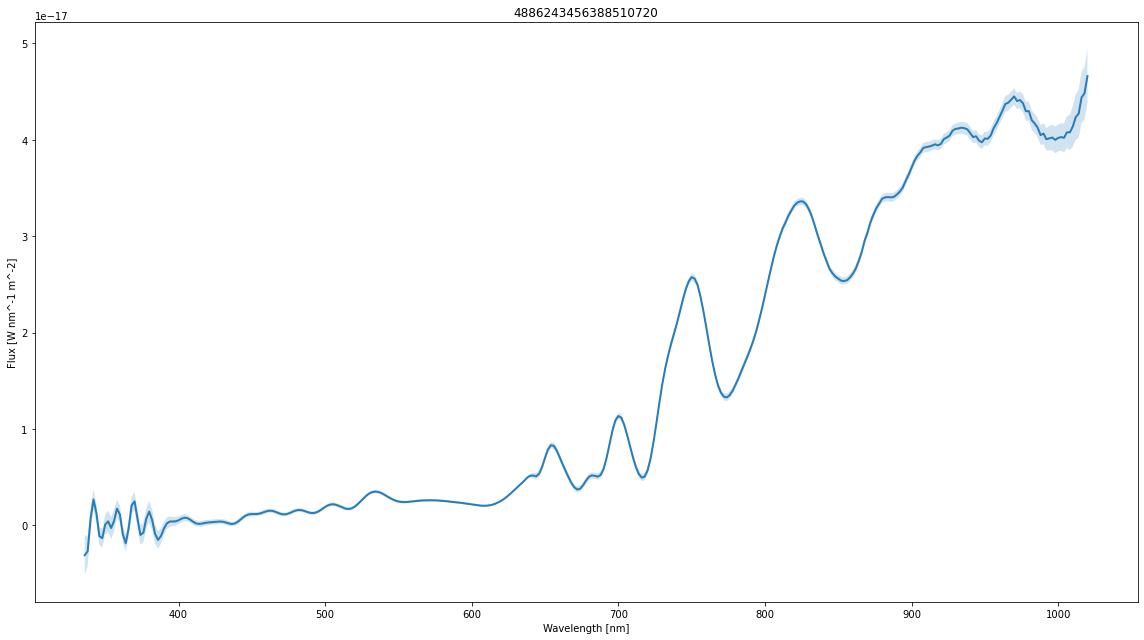

Geometric progression (log) sampling


In [136]:
from gaiaxpy import plot_spectra

print('Default sampling')
# Do not show the legend as there's only one source in the data
plot_spectra(converted_spectra, sampling=sampling, legend=False)
print('Geometric progression (log) sampling')
#plot_spectra(first_spectra_geom, sampling=geom_sampling, legend=False)

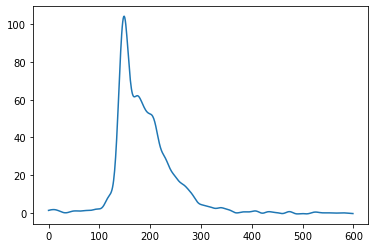

In [128]:
plt.plot(converted_spectra.flux[0])

INFO: Query finished. [astroquery.utils.tap.core]


             source_id                                               flux  \
0  4886243456388510720  [-3.0996482192574465e-18, -2.705067443114287e-...   

                                          flux_error  
0  [2.1086648450044356e-18, 1.5328441207492957e-1...  
INFO: Query finished. [astroquery.utils.tap.core]


             source_id                                               flux  \
0  4886243456388510720  [-3.294265388096386e-17, -1.6612028561636802e-...   

                                          flux_error  
0  [1.889128586758812e-17, 1.0320298022439356e-17...  
INFO: Query finished. [astroquery.utils.tap.core]


                                                                                      0/1 [00:00<?, ?spec/s]

Default sampling


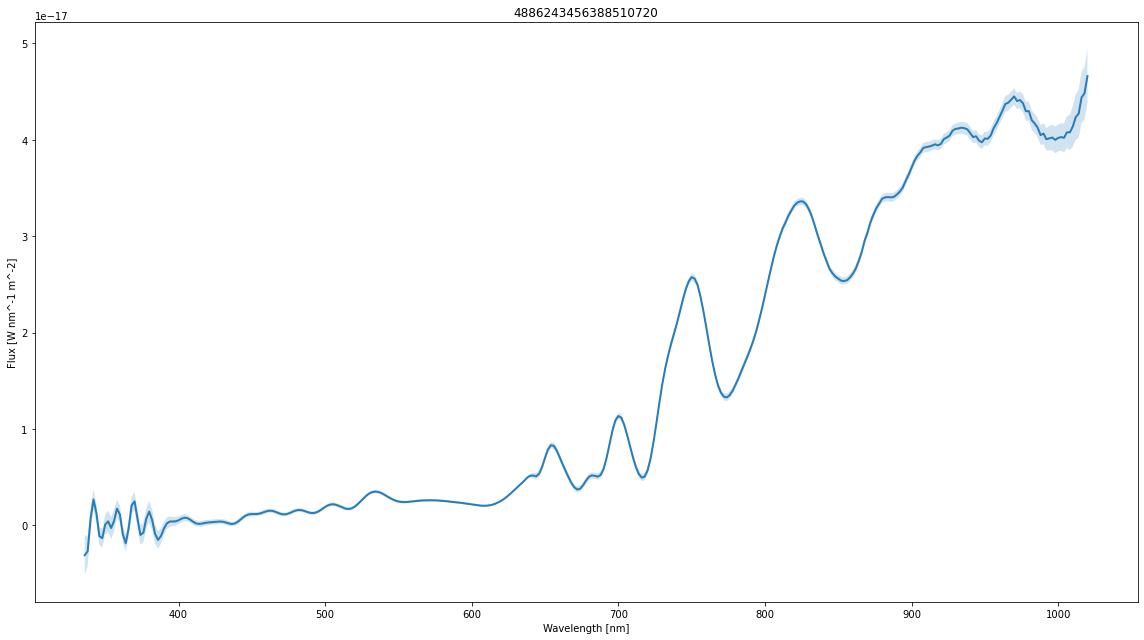

Geometric progression (log) sampling


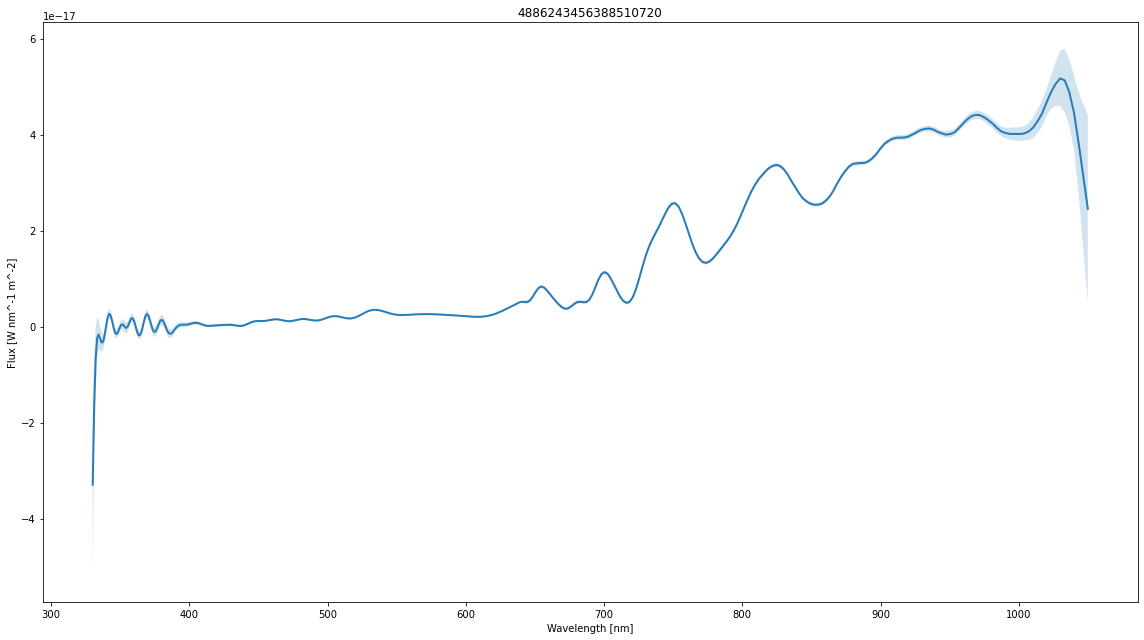

Truncated


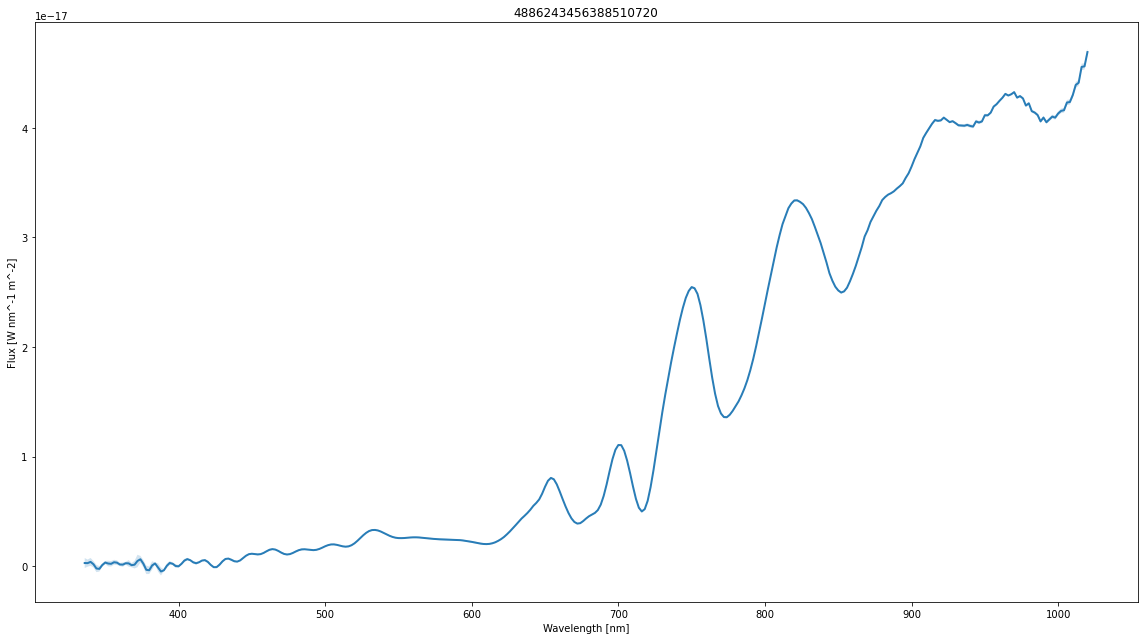

In [143]:
query_input = "select source_id from gaiadr3.gaia_source where has_xp_continuous = 'True' and source_id = 4886243456388510720"
calibrated_spectra, sampling = calibrate(query_input)
print(calibrated_spectra)
calibrated_spectra_geom, geom_sampling = calibrate(query_input, sampling=np.geomspace(330,1049.9999999999, 361))
print(calibrated_spectra_geom)
truncated_spectra, sampling2 = calibrate(query_input, truncation=True)
print("Default sampling")
# Do not show the legend as there’s only one source in the data
plot_spectra(calibrated_spectra, sampling=sampling, legend=False)
print("Geometric progression (log) sampling")
plot_spectra(calibrated_spectra_geom, sampling=geom_sampling, legend=False)
print("Truncated")
plot_spectra(truncated_spectra, sampling=sampling2, legend=False)
plt.show()






In [97]:
arr=np.array(tables[0]['bp_coefficients'])[0]
#plt.plot(arr)

In [ ]:
tables     # Change the figsize to e.g. figsize=[30,7] to increase the size of the displayed image.
source_ids_i = iter(source_ids)

In [ ]:
folder='/volumes/LaCie/hejazi/spectra/'
folder='/users/caganze/'

In [ ]:

for idx in range(len(source_ids)):
    filename=folder+'/id_{}.csv'.format(source_ids[idx])
    print (filename)
    t= tables[idx]
    t.to_pandas().to_csv(filename)

In [ ]:
t.to_pandas()

In [ ]:
len(IDS), len(tables), len(coord)